# Neural networks
## Overview
Our goal is to learn a model $\hat{y}$ that models $y$ given $X$. You'll notice that neural networks are just extensions of the generalized linear methods we've seen so far but with non-linear activation functions since our data will be highly non-linear.

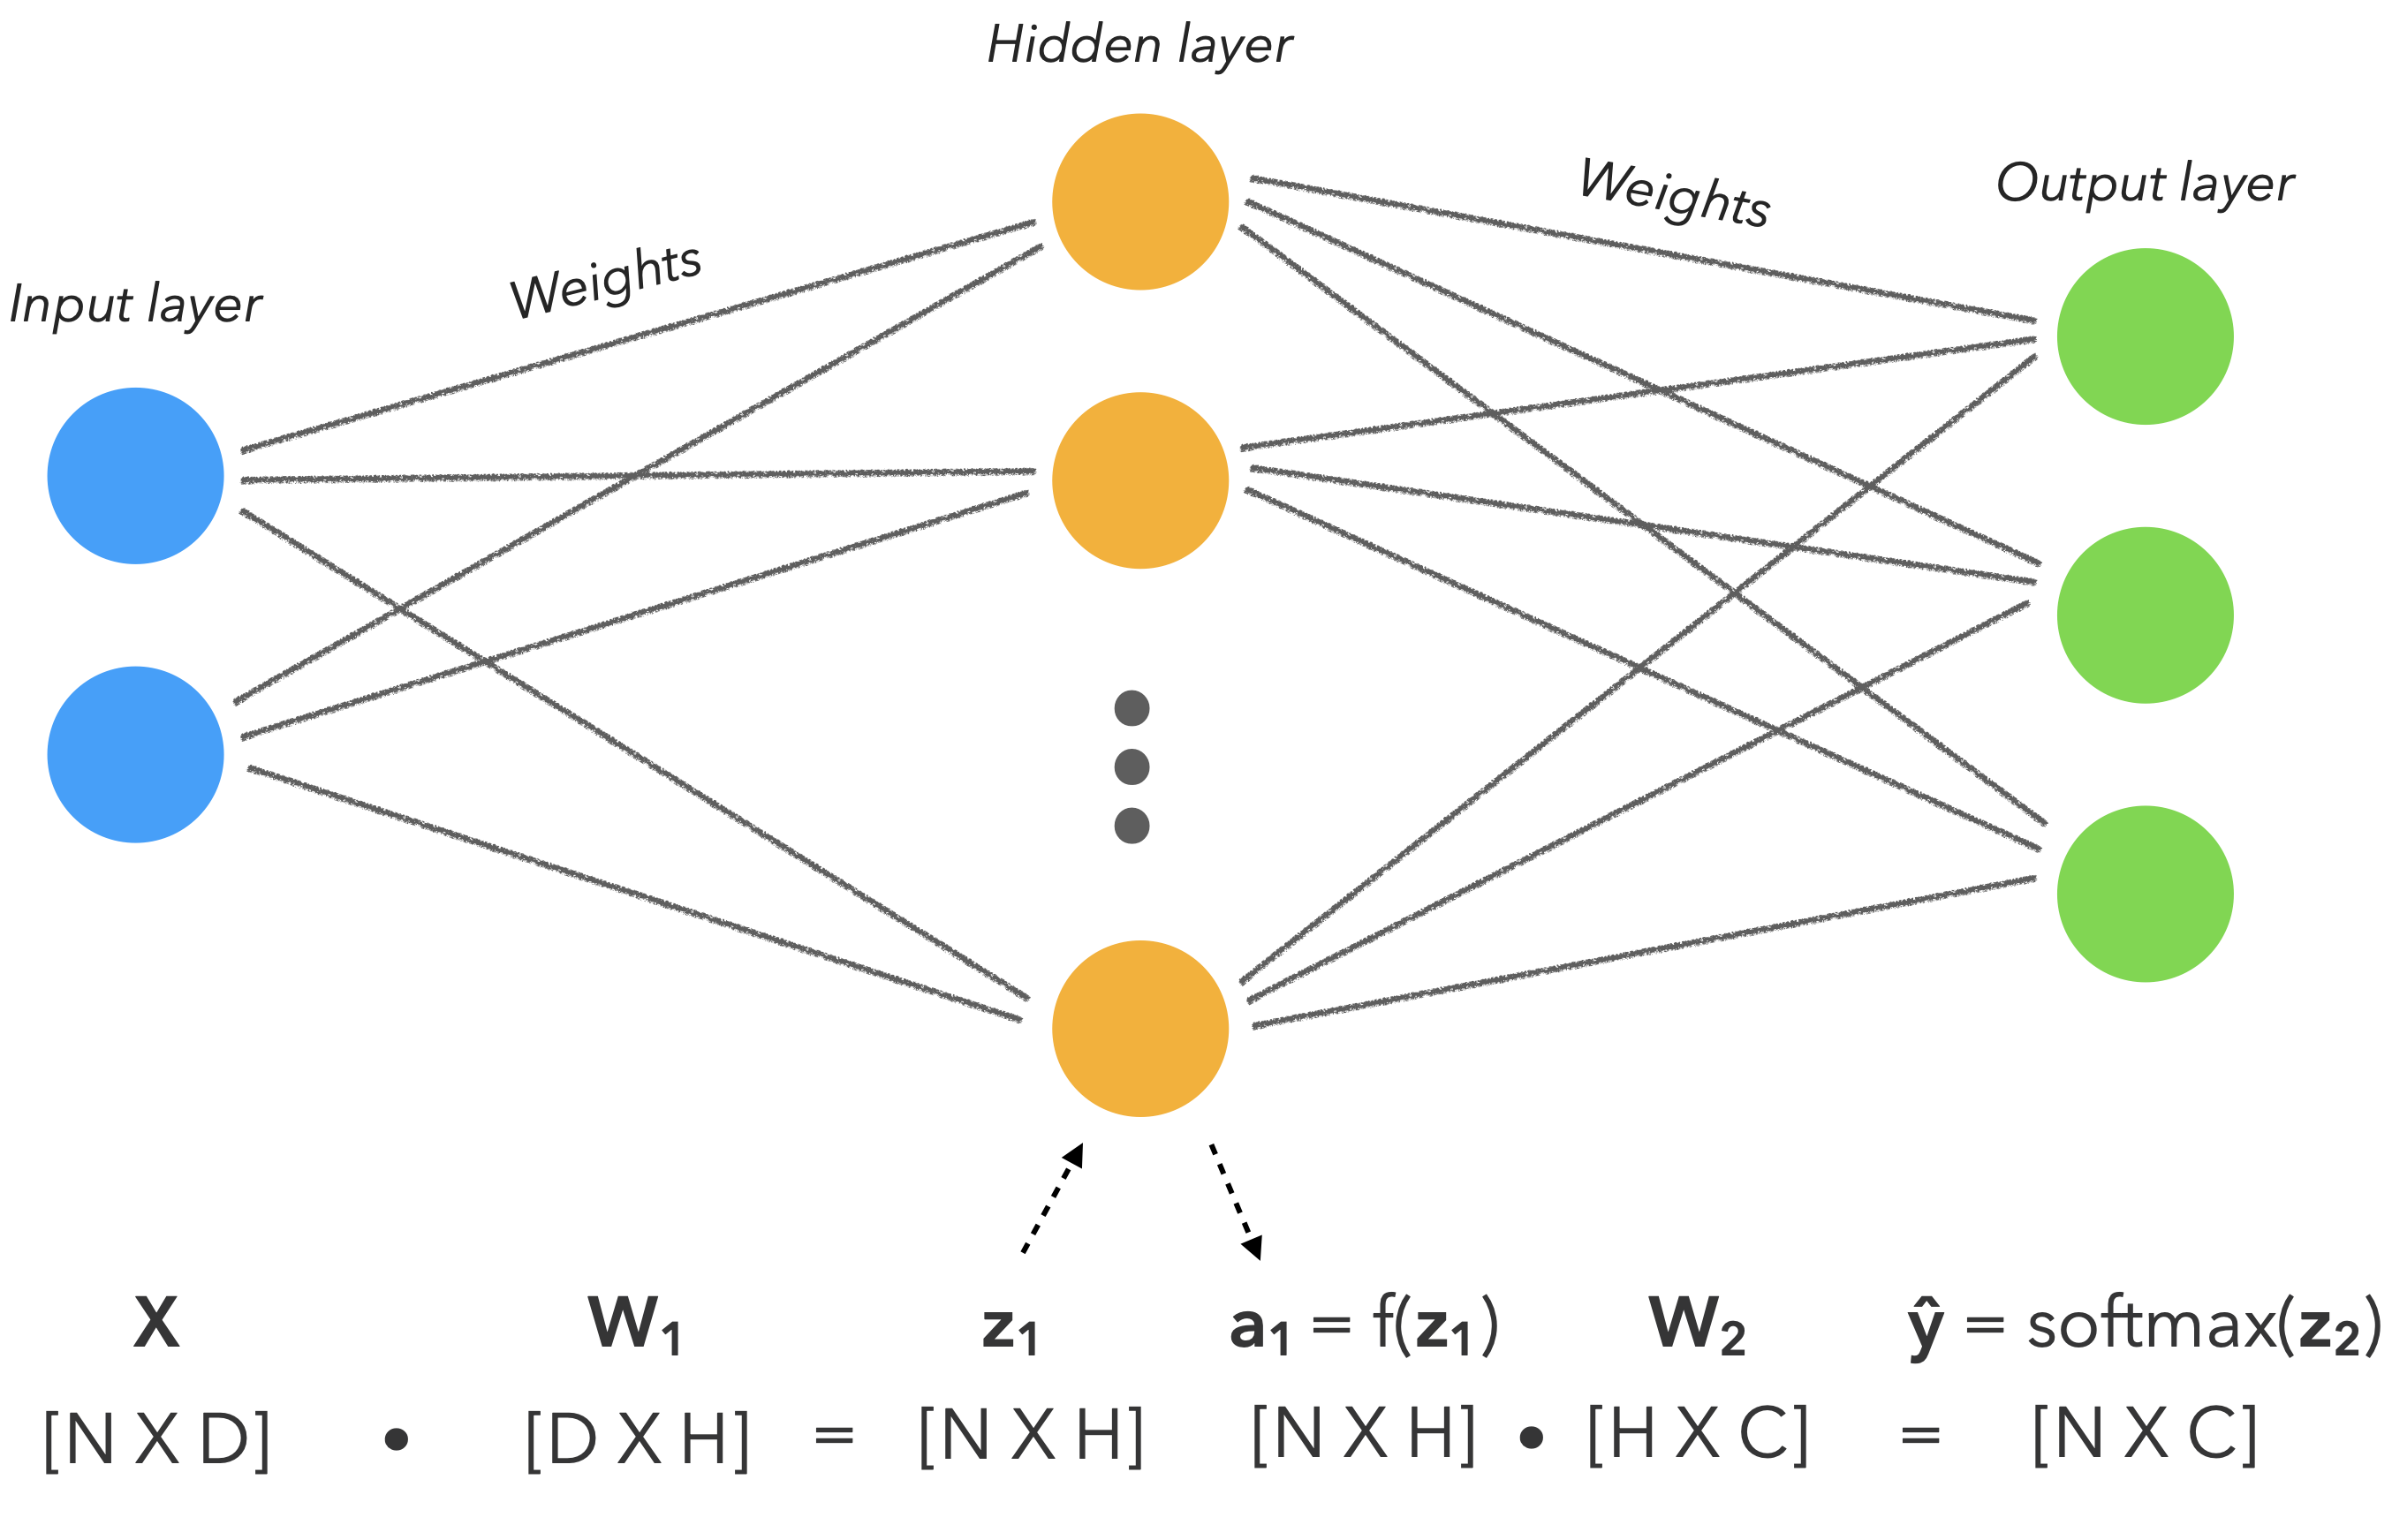

- **Objective**:
  - Predict the probability of class $y$ given the inputs $X$. Non-linearity is introduced to model the complex, non-linear data.
- **Advantages**:
  - Can model non-linear patterns in the data really well.
- **Disadvantages**:
  - Overfits easily.
  - Computationally intensive as network increases in size.
  - Not easily interpretable.
- **Miscellaneous**:
  - Future neural network architectures that we'll see use the MLP as a modular unit for feed forward operations (affine transformation (XW) followed by a non-linear operation).

## Set up
We'll set our seeds for reproducibility.

In [1]:
import numpy as np

import random

In [2]:
SEED = 1234

In [3]:
# Set seed for reproducibility
rng = np.random.default_rng(SEED)
random.seed(SEED)

### Load data
I created some non-linearly separable spiral data so let's go ahead and download it for our classification task.

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

In [75]:
from dataclasses import dataclass, field

from typing import Callable, Iterable, List, Protocol


golden_ratio = (1 + np.sqrt(5)) / 2


@dataclass
class ArchimedianRadius:
    factor: float = 1.0
    
    def __call__(self, phi):
        return self.factor * phi


@dataclass
class Spiral:
    
    radius: Callable[[float], float]
    shift: float = 0.0

    def get_x_y(self, angle: float):
        r = self.radius(angle)
        x = r * np.cos(angle + self.shift)
        y = r * np.sin(angle + self.shift)
        
        return x, y


class Distribution(Protocol):
    
    def generate(self, rng: np.random.Generator, size: tuple = None) -> np.ndarray: ...


@dataclass
class Normal(Distribution):
    loc: float = 0.0
    scale: float = 1.0    

    def generate(self, rng: np.random.Generator, size: tuple = None) -> np.ndarray:
        return rng.normal(self.loc, self.scale, size=size)


fr = ArchimedianRadius(golden_ratio)

spiral0 = Spiral(fr)
spiral1 = Spiral(fr, shift=2/3*np.pi)
spiral2 = Spiral(fr, shift=4/3*np.pi)
spirals = [spiral0, spiral1, spiral2]

rng = np.random.default_rng(SEED)


def generate_spirals(
    spirals: Iterable[Spiral],
    angle: np.ndarray = None,
    rng: np.random.Generator = None,
    distribution: Distribution = None,
) -> pd.DataFrame:
    
    if angle is None:
        angle = np.linspace(0.0, 5.0, num=500)
    
    if rng is None:
        rng = np.random.default_rng(SEED)

    if distribution is None:
        distribution = Normal(0.0, 1.0)

    xys = [spiral.get_x_y(angle) for spiral in spirals]
    eps = distribution.generate(rng, size=(len(spirals), 2, len(angle)))

    dfs = [
        pd.DataFrame({'X1': x + eps[i, 0], 'X2': y + eps[i, 1], 'color': f'c{i+1}'})
        for (i, (x, y)) in enumerate(xys)
    ]
    df = pd.concat(dfs, axis=0)
    
    return df




In [6]:
df = generate_spirals(spirals, distribution=Normal(scale=0.2))
df

,X1,X2,color
0,-0.320767,0.145567,c1
1,0.029032,0.132386,c1
2,0.180597,0.206408,c1
3,0.079140,0.094877,c1
4,0.237548,0.109245,c1
...,...,...,...
495,-7.606522,2.025510,c3
496,-7.573552,1.841280,c3
497,-7.548512,2.280927,c3
498,-7.981224,1.829948,c3


In [7]:
# Data shapes
X = df[["X1", "X2"]].values
y = df["color"].values
print ("X: ", np.shape(X))
print ("y: ", np.shape(y))

X:  (1500, 2)
y:  (1500,)


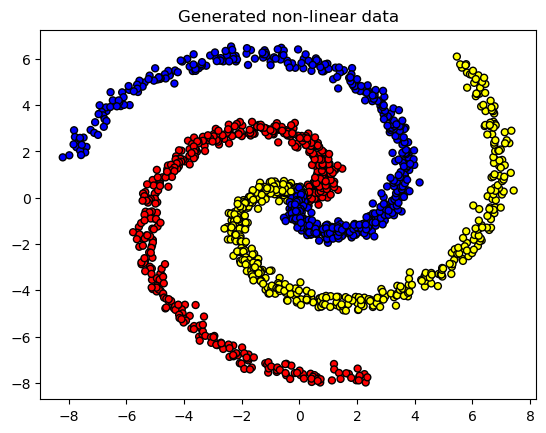

In [8]:
# Visualize data
plt.title("Generated non-linear data")
colors = {"c1": "red", "c2": "yellow", "c3": "blue"}
plt.scatter(X[:, 0], X[:, 1], c=[colors[_y] for _y in y], edgecolors="k", s=25)
plt.show()

### Split data
We'll shuffle our dataset (since it's ordered by class) and then create our data splits (stratified on class).

In [9]:
import collections
from sklearn.model_selection import train_test_split

In [10]:
TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 0.15

In [11]:
def train_val_test_split(X, y, train_size):
    """Split dataset into data splits."""
    X_train, X_, y_train, y_ = train_test_split(X, y, train_size=TRAIN_SIZE, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_, y_, train_size=0.5, stratify=y_)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [12]:
# Create data splits
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X=X, y=y, train_size=TRAIN_SIZE)

print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print (f"Sample point: {X_train[0]} → {y_train[0]}")

X_train: (1050, 2), y_train: (1050,)
X_val: (225, 2), y_val: (225,)
X_test: (225, 2), y_test: (225,)
Sample point: [ 1.53241661 -1.32176267] → c3


### Label encoding
In the previous lesson we wrote our own label encoder class to see the inner functions but this time we'll use scikit-learn `LabelEncoder` class which does the same operations as ours.

In [14]:
from sklearn.preprocessing import LabelEncoder

In [15]:
# Output vectorizer
label_encoder = LabelEncoder()

In [16]:
# Fit on train data
label_encoder = label_encoder.fit(y_train)
classes = list(label_encoder.classes_)
print (f"classes: {classes}")

classes: ['c1', 'c2', 'c3']


In [17]:
# Convert labels to tokens
print (f"y_train[0]: {y_train[0]}")
y_train = label_encoder.transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)
print (f"y_train[0]: {y_train[0]}")

y_train[0]: c3
y_train[0]: 2


In [18]:
# Class weights
counts = np.bincount(y_train)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"counts: {counts}\nweights: {class_weights}")

counts: [350 350 350]
weights: {0: 0.002857142857142857, 1: 0.002857142857142857, 2: 0.002857142857142857}


### Standardize data
We need to standardize our data (zero mean and unit variance) so a specific feature's magnitude doesn't affect how the model learns its weights. We're only going to standardize the inputs X because our outputs y are class values.

In [19]:
from sklearn.preprocessing import StandardScaler


In [20]:
# Standardize the data (mean=0, std=1) using training data
X_scaler = StandardScaler().fit(X_train)

In [21]:
# Apply scaler on training and test data (don't standardize outputs for classification)
X_train = X_scaler.transform(X_train)
X_val = X_scaler.transform(X_val)
X_test = X_scaler.transform(X_test)

In [22]:
# Check (means should be ~0 and std should be ~1)
print (f"X_test[0]: mean: {np.mean(X_test[:, 0], axis=0):.1f}, std: {np.std(X_test[:, 0], axis=0):.1f}")
print (f"X_test[1]: mean: {np.mean(X_test[:, 1], axis=0):.1f}, std: {np.std(X_test[:, 1], axis=0):.1f}")

X_test[0]: mean: -0.0, std: 1.0
X_test[1]: mean: -0.0, std: 1.0


## Linear model

Before we get to our neural network, we're going to motivate non-linear activation functions by implementing a generalized linear model (logistic regression). We'll see why linear models (with linear activations) won't suffice for our dataset.

In [23]:
import torch

In [24]:
# Set seed for reproducibility
torch.manual_seed(SEED)

### Model
We'll create our linear model using one layer of weights.

In [25]:
from torch import nn
import torch.nn.functional as F

In [26]:
INPUT_DIM = X_train.shape[1] # X is 2-dimensional
HIDDEN_DIM = 100
NUM_CLASSES = len(classes) # 3 classes

In [28]:
class LinearModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x_in):
        z = self.fc1(x_in) # linear activation
        z = self.fc2(z)
        return z

In [29]:
# Initialize model
model = LinearModel(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, num_classes=NUM_CLASSES)
print (model.named_parameters)

<bound method Module.named_parameters of LinearModel(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=3, bias=True)
)>


### Training
We'll go ahead and train our initialized model for a few epochs.

In [30]:
from torch.optim import Adam

In [31]:
LEARNING_RATE = 1e-2
NUM_EPOCHS = 10
BATCH_SIZE = 32

In [32]:
# Define Loss
class_weights_tensor = torch.Tensor(list(class_weights.values()))
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [34]:
# Accuracy
def accuracy_fn(y_pred, y_true):
    n_correct = torch.eq(y_pred, y_true).sum().item()
    accuracy = (n_correct / len(y_pred)) * 100
    return accuracy

In [36]:
# Optimizer
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

In [37]:
# Convert data to tensors
X_train = torch.Tensor(X_train)
y_train = torch.LongTensor(y_train)
X_val = torch.Tensor(X_val)
y_val = torch.LongTensor(y_val)
X_test = torch.Tensor(X_test)
y_test = torch.LongTensor(y_test)

In [38]:
# Training
for epoch in range(NUM_EPOCHS):
    # Forward pass
    y_pred = model(X_train)

    # Loss
    loss = loss_fn(y_pred, y_train)

    # Zero all gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    if epoch%1==0:
        predictions = y_pred.max(dim=1)[1] # class
        accuracy = accuracy_fn(y_pred=predictions, y_true=y_train)
        print (f"Epoch: {epoch} | loss: {loss:.2f}, accuracy: {accuracy:.1f}")

Epoch: 0 | loss: 1.20, accuracy: 39.9
Epoch: 1 | loss: 1.00, accuracy: 42.0
Epoch: 2 | loss: 0.92, accuracy: 43.0
Epoch: 3 | loss: 0.91, accuracy: 42.3
Epoch: 4 | loss: 0.94, accuracy: 43.4
Epoch: 5 | loss: 0.96, accuracy: 43.5
Epoch: 6 | loss: 0.97, accuracy: 43.2
Epoch: 7 | loss: 0.97, accuracy: 43.0
Epoch: 8 | loss: 0.97, accuracy: 42.7
Epoch: 9 | loss: 0.96, accuracy: 42.0


### Evaluation
Now let's see how well our linear model does on our non-linear spiral data.

In [39]:
import json
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

In [41]:
def get_metrics(y_true, y_pred, classes):
    """Per-class performance metrics."""
    # Performance
    performance = {"overall": {}, "class": {}}

    # Overall performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    performance["overall"]["precision"] = metrics[0]
    performance["overall"]["recall"] = metrics[1]
    performance["overall"]["f1"] = metrics[2]
    performance["overall"]["num_samples"] = np.float64(len(y_true))

    # Per-class performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average=None)
    for i in range(len(classes)):
        performance["class"][classes[i]] = {
            "precision": metrics[0][i],
            "recall": metrics[1][i],
            "f1": metrics[2][i],
            "num_samples": np.float64(metrics[3][i]),
        }

    return performance

In [42]:
# Predictions
y_prob = F.softmax(model(X_test), dim=1)
print (f"sample probability: {y_prob[0]}")
y_pred = y_prob.max(dim=1)[1]
print (f"sample class: {y_pred[0]}")

sample probability: tensor([0.3596, 0.2683, 0.3720], grad_fn=<SelectBackward0>)
sample class: 2


In [44]:
# Performance
performance = get_metrics(y_true=y_test, y_pred=y_pred, classes=classes)
print (json.dumps(performance, indent=2))

{
  "overall": {
    "precision": 0.4098015873015873,
    "recall": 0.4088888888888889,
    "f1": 0.40904214559386975,
    "num_samples": 225.0
  },
  "class": {
    "c1": {
      "precision": 0.3875,
      "recall": 0.41333333333333333,
      "f1": 0.4000000000000001,
      "num_samples": 75.0
    },
    "c2": {
      "precision": 0.42857142857142855,
      "recall": 0.4,
      "f1": 0.4137931034482759,
      "num_samples": 75.0
    },
    "c3": {
      "precision": 0.41333333333333333,
      "recall": 0.41333333333333333,
      "f1": 0.41333333333333333,
      "num_samples": 75.0
    }
  }
}


In [45]:
def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = plt.cm.Spectral

    X_test = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
    y_pred = F.softmax(model(X_test), dim=1)
    _, y_pred = y_pred.max(dim=1)
    y_pred = y_pred.reshape(xx.shape)
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

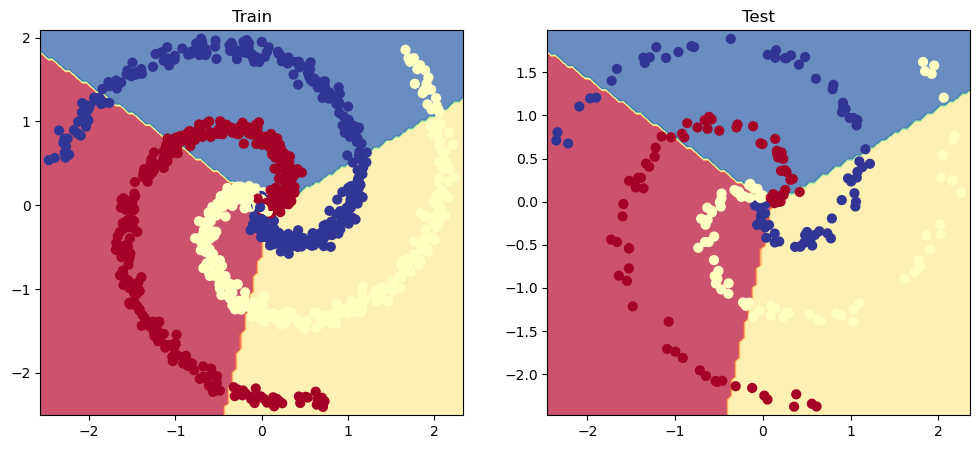

In [46]:
# Visualize the decision boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)
plt.show()

## Activation functions
Using the generalized linear method (logistic regression) yielded poor results because of the non-linearity present in our data yet our activation functions were linear. We need to use an activation function that can allow our model to learn and map the non-linearity in our data. There are many different options so let's explore a few.

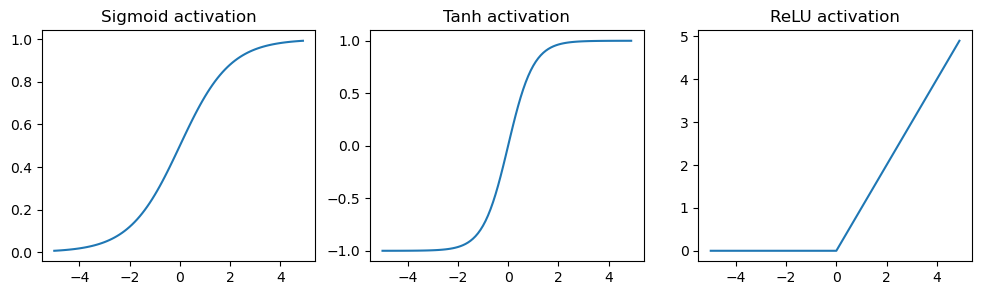

In [47]:
# Fig size
plt.figure(figsize=(12,3))

# Data
x = torch.arange(-5., 5., 0.1)

# Sigmoid activation (constrain a value between 0 and 1.)
plt.subplot(1, 3, 1)
plt.title("Sigmoid activation")
y = torch.sigmoid(x)
plt.plot(x.numpy(), y.numpy())

# Tanh activation (constrain a value between -1 and 1.)
plt.subplot(1, 3, 2)
y = torch.tanh(x)
plt.title("Tanh activation")
plt.plot(x.numpy(), y.numpy())

# Relu (clip the negative values to 0)
plt.subplot(1, 3, 3)
y = F.relu(x)
plt.title("ReLU activation")
plt.plot(x.numpy(), y.numpy())

# Show plots
plt.show()

The ReLU activation function $\max(0, z)$ is by far the most widely used activation function for neural networks. But as you can see, each activation function has its own constraints so there are circumstances where you'll want to use different ones. For example, if we need to constrain our outputs between 0 and 1, then the sigmoid activation is the best choice.

> In some cases, using a ReLU activation function may not be sufficient. For instance, when the outputs from our neurons are mostly negative, the activation function will produce zeros. This effectively creates a "dying ReLU" and a recovery is unlikely. To mitigate this effect, we could lower the learning rate or use alternative ReLU activations, ex. leaky ReLU or parametric ReLU (PReLU), which have a small slope for negative neuron outputs.

## NumPy
Now let's create our multilayer perceptron (MLP) which is going to be exactly like the logistic regression model but with the activation function to map the non-linearity in our data.

> It's normal to find the math and code in this section slightly complex. You can still read each of the steps to build intuition for when we implement this using PyTorch.

Our goal is to learn a model $\hat{y}$ that models $y$ given $X$. You'll notice that neural networks are just extensions of the generalized linear methods we've seen so far but with non-linear activation functions since our data will be highly non-linear.

$$
\begin{align*}
z_1 &= XW_1 \\
a_1 &= f(z_1) \\
z_2 &= a_1W_2 \\
\hat{y} &= \text{softmax}(z_2)
\end{align*}
$$

### Initialize weights
`Step 1`: Randomly initialize the model's weights $W$ (we'll cover more effective initialization strategies later in this lesson).

In [102]:
# Initialize first layer's weights
W1_0 = 0.01 * np.random.randn(INPUT_DIM, HIDDEN_DIM)
b1_0 = np.zeros((1, HIDDEN_DIM))
W1 = W1_0.copy()
b1 = b1_0.copy()
print (f"W1: {W1.shape}")
print (f"b1: {b1.shape}")

W1: (2, 100)
b1: (1, 100)


### Model
`Step 2`: Feed inputs $X$ into the model to do the forward pass and receive the probabilities. First we pass the inputs into the first layer.

$$
z_1 = XW_1
$$

In [49]:
# z1 = [NX2] · [2X100] + [1X100] = [NX100]
z1 = np.dot(X_train, W1) + b1
print (f"z1: {z1.shape}")

z1: (1050, 100)


Next we apply the non-linear activation function, ReLU ($\max(0, z)$) in this case.
$$
a_1 = f(z_1)
$$

In [50]:
# Apply activation function
a1 = np.maximum(0, z1) # ReLU
print (f"a_1: {a1.shape}")

a_1: (1050, 100)


We pass the activations to the second layer to get our logits.
$$
z_2 = a_1W_2
$$

In [101]:
# Initialize second layer's weights
W2_0 = 0.01 * np.random.randn(HIDDEN_DIM, NUM_CLASSES)
b2_0 = np.zeros((1, NUM_CLASSES))
W2 = W2_0.copy()
b2 = b2_0.copy()
print (f"W2: {W2.shape}")
print (f"b2: {b2.shape}")

W2: (100, 3)
b2: (1, 3)


In [52]:
# z2 = logits = [NX100] · [100X3] + [1X3] = [NX3]
logits = np.dot(a1, W2) + b2
print (f"logits: {logits.shape}")
print (f"sample: {logits[0]}")

logits: (1050, 3)
sample: [ 0.00035849 -0.00036269 -0.00010363]


We'll apply the softmax function to normalize the logits and obtain class probabilities.
$$
\hat{y} = \text{softmax}(z_2)
$$

In [54]:
# Normalization via softmax to obtain class probabilities
def softmax(logits):
    exp_logits = np.exp(logits)
    y_hat = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
    
    return y_hat


y_hat = softmax(logits)
print (f"y_hat: {y_hat.shape}")
print (f"sample: {y_hat[0]}")

y_hat: (1050, 3)
sample: [0.33346482 0.33322442 0.33331076]


In [57]:
logits

array([[ 3.58485898e-04, -3.62692473e-04, -1.03631317e-04],
       [ 1.07308023e-04, -4.50376408e-04, -1.21319085e-04],
       [ 3.31059489e-04, -3.53089657e-04, -1.07504684e-04],
       ...,
       [ 3.19732525e-05, -1.71889265e-03, -4.40127239e-04],
       [-1.13255534e-03, -9.54450502e-04, -2.68791595e-04],
       [ 2.32678261e-04, -4.47134939e-04, -1.26742568e-04]])

### Loss
`Step 3`: Compare the predictions $\hat{y}$ (ex. [0.3, 0.3, 0.4]) with the actual target values $y$ (ex. class 2 would look like [0, 0, 1]) with the objective (cost) function to determine loss $J$. A common objective function for classification tasks is cross-entropy loss.

$$
J(\theta) = -\sum_i \log(\hat{y}_i) = -\sum_i\log\left(\frac{e^{X_iW_{y_i}}}{\sum_j e^{X_jW_j}}\right)
$$

(*) Although the model computes a probability for every class, $\hat{y}_i$ are understood as the probabilities that correspond with the actual target value $y$. Hence the $W_{y_i}$ weight picked here.

(**) bias term ($b$) excluded to avoid crowding the notations

In [56]:
# Loss
correct_class_logprobs = -np.log(y_hat[range(len(y_hat)), y_train])
loss = np.sum(correct_class_logprobs) / len(y_train)
print (f"loss: {loss:.2f}")

loss: 1.10


### Gradients

`Step 4`: Calculate the gradient of loss $J(\theta)$ w.r.t to the model weights.

The gradient of the loss w.r.t to
$$
W_2
$$
is the same as the gradients from logistic regression since $\hat{y}=\text{softmax}(z_2)$.

![gradients_W_2.png](gradients_W_2.png)

The gradient of the loss w.r.t $W_1$ is a bit trickier since we have to backpropagate through two sets of weights.

![gradients_W_1.png](gradients_W_1.png)

In [66]:
# dJ/dW2
dscores = y_hat
dscores[range(len(y_hat)), y_train] -= 1
dscores /= len(y_train)
dW2 = np.dot(a1.T, dscores)
db2 = np.sum(dscores, axis=0, keepdims=True)

In [67]:
# dJ/dW1
dhidden = np.dot(dscores, W2.T)
dhidden[a1 <= 0] = 0 # ReLu backprop
dW1 = np.dot(X_train.T, dhidden)
db1 = np.sum(dhidden, axis=0, keepdims=True)

### Update weights
`Step 5`: Update the weights $W$ using a small learning rate $\alpha$. The updates will penalize the probability for the incorrect classes ($j$) and encourage a higher probability for the correct class ($y$).

$$
W_i := W_i - \alpha \frac{\partial J}{\partial W_i}
$$

In [68]:
# Update weights
W1 += -LEARNING_RATE * dW1
b1 += -LEARNING_RATE * db1
W2 += -LEARNING_RATE * dW2
b2 += -LEARNING_RATE * db2

### Training

`Step 6`: Repeat steps 2 - 4 until the model performs well.

In [69]:
# Convert tensors to NumPy arrays
X_train = X_train.numpy()
y_train = y_train.numpy()
X_val = X_val.numpy()
y_val = y_val.numpy()
X_test = X_test.numpy()
y_test = y_test.numpy()

In [165]:
# Initialize random weights
W1_0 = 0.01 * np.random.randn(INPUT_DIM, HIDDEN_DIM)
b1_0 = np.zeros((1, HIDDEN_DIM))
W1 = W1_0.copy()
b1 = b1_0.copy()
W2_0 = 0.01 * np.random.randn(HIDDEN_DIM, NUM_CLASSES)
b2_0 = np.zeros((1, NUM_CLASSES))
W2 = W2_0.copy()
b2 = b2_0.copy()

# Training loop
for epoch_num in range(1000):

    # First layer forward pass [NX2] · [2X100] = [NX100]
    z1 = np.dot(X_train, W1) + b1

    # Apply activation function
    a1 = np.maximum(0, z1) # ReLU

    # z2 = logits = [NX100] · [100X3] = [NX3]
    logits = np.dot(a1, W2) + b2

    # Normalization via softmax to obtain class probabilities
    exp_logits = np.exp(logits)
    y_hat = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

    # Loss
    correct_class_logprobs = -np.log(y_hat[range(len(y_hat)), y_train])
    loss = np.sum(correct_class_logprobs) / len(y_train)

    # show progress
    if epoch_num%100 == 0:
        # Accuracy
        y_pred = np.argmax(logits, axis=1)
        accuracy =  np.mean(np.equal(y_train, y_pred))
        print (f"Epoch: {epoch_num}, loss: {loss:.3f}, accuracy: {accuracy:.3f}")

    # dJ/dW2
    dscores = y_hat
    dscores[range(len(y_hat)), y_train] -= 1
    dscores /= len(y_train)
    dW2 = np.dot(a1.T, dscores)
    db2 = np.sum(dscores, axis=0, keepdims=True)

    # dJ/dW1
    dhidden = np.dot(dscores, W2.T)
    dhidden[a1 <= 0] = 0 # ReLu backprop
    dW1 = np.dot(X_train.T, dhidden)
    db1 = np.sum(dhidden, axis=0, keepdims=True)

    # Update weights
    W1 += -1e0 * dW1
    b1 += -1e0 * db1
    W2 += -1e0 * dW2
    b2 += -1e0 * db2

Epoch: 0, loss: 1.099, accuracy: 0.372
Epoch: 100, loss: 0.386, accuracy: 0.872
Epoch: 200, loss: 0.179, accuracy: 0.940
Epoch: 300, loss: 0.124, accuracy: 0.955
Epoch: 400, loss: 0.103, accuracy: 0.966
Epoch: 500, loss: 0.092, accuracy: 0.968
Epoch: 600, loss: 0.085, accuracy: 0.970
Epoch: 700, loss: 0.080, accuracy: 0.970
Epoch: 800, loss: 0.077, accuracy: 0.971
Epoch: 900, loss: 0.074, accuracy: 0.971


### Evaluation
Now let's see how our model performs on the test (hold-out) data split.

In [166]:
def get_accuracy(y_hat, y_train):
    y_pred = np.argmax(y_hat, axis=1)
    accuracy =  np.mean(np.equal(y_train, y_pred))

    return accuracy


def show_progress(model, epoch_num: int, y_hat, y_train):
    if epoch_num%100 == 0:
        loss = model.get_loss(y_hat, y_train)
        accuracy = get_accuracy(y_hat, y_train)
        print (f"Epoch: {epoch_num}, loss: {loss:.3f}, accuracy: {accuracy:.3f}")


@dataclass
class MLPFromScratch():
    """From scratch implementation of a multi-layer perceptron.
    
    Improvement points:
    - Split out the loss and train methods into separate functions outside the class.
      They can be varied depending on the use case.
    """
    
    W1: np.ndarray
    b1: np.ndarray
    W2: np.ndarray
    b2: np.ndarray

    def activation(self, x):
        z1 = np.dot(x, self.W1) + self.b1
        a1 = np.maximum(0, z1)
        
        return a1

    def predict(self, x):
        a1 = self.activation(x)
        logits = np.dot(a1, self.W2) + self.b2
        exp_logits = np.exp(logits)
        y_hat = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
        return y_hat
    
    @classmethod
    def random(cls, input_dim: int = None, hidden_dim: int = None, num_classes: int = None):
        if input_dim is None:
            input_dim = INPUT_DIM
        
        if hidden_dim is None:
            hidden_dim = HIDDEN_DIM
        
        if num_classes is None:
            num_classes = NUM_CLASSES
        
        W1 = 0.01 * np.random.randn(input_dim, hidden_dim)
        b1 = np.zeros((1, hidden_dim))
        W2 = 0.01 * np.random.randn(hidden_dim, num_classes)
        b2 = np.zeros((1, num_classes))
        
        return cls(W1=W1, b1=b1, W2=W2, b2=b2)

    def get_loss(self, y_hat, y_train):
        correct_class_logprobs = -np.log(y_hat[range(len(y_hat)), y_train])
        loss = np.sum(correct_class_logprobs) / len(y_train)
        
        return loss

    def get_gradient(self, x, y_hat, y_train):
        a1 = self.activation(x)
        
        # dJ/dW2
        dscores = y_hat.copy()
        dscores[range(len(y_hat)), y_train] -= 1
        dscores /= len(y_train)
        dW2 = np.dot(a1.T, dscores)
        db2 = np.sum(dscores, axis=0, keepdims=True)

        # dJ/dW1
        dhidden = np.dot(dscores, self.W2.T)
        dhidden[a1 <= 0] = 0 # ReLu backprop
        dW1 = np.dot(x.T, dhidden)
        db1 = np.sum(dhidden, axis=0, keepdims=True)
        
        return dW1, db1, dW2, db2

    def update_weights(self, gradient, learning_rate: float):
        dW1, db1, dW2, db2 = gradient
        self.W1 += -learning_rate * dW1
        self.b1 += -learning_rate * db1
        self.W2 += -learning_rate * dW2
        self.b2 += -learning_rate * db2  


def simple_train(model, x, y, n_epochs: int = 1000, learning_rate: float = 1e0, 
                 callback: Callable = None):
    
    if callback is None:
        callback = show_progress
    
    for epoch_num in range(n_epochs):
        y_hat = model.predict(x)
        callback(model, epoch_num, y_hat, y)
        gradient = model.get_gradient(x, y_hat, y)
        model.update_weights(gradient, learning_rate)



In [167]:
model = MLPFromScratch(W1_0.copy(), b1_0.copy(), W2_0.copy(), b2_0.copy())
simple_train(model, X_train, y_train)


Epoch: 0, loss: 1.099, accuracy: 0.372
Epoch: 100, loss: 0.386, accuracy: 0.872
Epoch: 200, loss: 0.179, accuracy: 0.940
Epoch: 300, loss: 0.124, accuracy: 0.955
Epoch: 400, loss: 0.103, accuracy: 0.966
Epoch: 500, loss: 0.092, accuracy: 0.968
Epoch: 600, loss: 0.085, accuracy: 0.970
Epoch: 700, loss: 0.080, accuracy: 0.970
Epoch: 800, loss: 0.077, accuracy: 0.971
Epoch: 900, loss: 0.074, accuracy: 0.971
